In [ ]:
!pip install qiskit
!pip install qiskit_aer                   #simulacion de alto desempeño
!pip install "qiskit[visualization]"      #visualizacion de los circitos cuanticos
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install -U qiskit qiskit-machine-learning qiskit-aer qiskit-algorithms



  Using cached qiskit-2.2.3-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)


In [ ]:
pip install qiskit qiskit-machine-learning torch scikit-learn pandas numpy



📥 Cargando dataset...
✅ Dataset cargado: 16,599 muestras, 19 features
Usando 'Goal' como variable objetivo (target).

⚛️ Circuito cuántico creado con 8 qubits y 3 repeticiones (full entanglement).


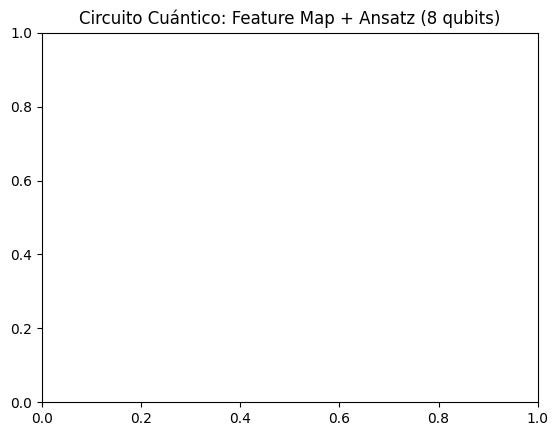


🚀 Entrenando modelo híbrido (clásico + cuántico)...

Epoch 01/2 | Train Loss: 0.000886 | Test Loss: 0.000038
Epoch 02/2 | Train Loss: 0.000033 | Test Loss: 0.000030

⏱️ Entrenamiento completado en 23605.0s

✅ Métricas de evaluación:
MSE  (Error cuadrático medio): 0.000030
MAE  (Error absoluto medio):  0.003541
RMSE (Raíz del MSE):          0.005475
💾 Modelo guardado en 'hybrid_qnn_regressor_8q.pth'


In [ ]:
"""
Hybrid Classical-Quantum Neural Network for Regression (Optimized + 8 Qubits + Circuit Visualization)
Dataset: elevators (loaded from remote URL)
"""

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
from dataclasses import dataclass

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, PauliFeatureMap
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


# ====================================================
# 🔧 CONFIGURACIÓN
# ====================================================
@dataclass
class Config:
    data_url: str = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
    num_qubits: int = 8
    ansatz_reps: int = 3
    batch_size: int = 32
    epochs: int = 2
    lr: float = 0.008
    test_size: float = 0.2
    random_state: int = 42
    seed: int = 42

cfg = Config()
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)


# ====================================================
# 📥 CARGA Y PREPROCESAMIENTO DE DATOS
# ====================================================
def load_elevators_dataset(url: str) -> pd.DataFrame:
    import requests
    resp = requests.get(url, timeout=20)
    resp.raise_for_status()
    lines = [l.strip() for l in resp.text.splitlines()]
    attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
    data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
    rows = [ln for ln in lines[data_start:] if ln and not ln.startswith("%")]
    data = [r.split(',') for r in rows]
    df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)
    return df


print("\n📥 Cargando dataset...")
df = load_elevators_dataset(cfg.data_url)
print(f"✅ Dataset cargado: {df.shape[0]:,} muestras, {df.shape[1]} features")

target_col = df.columns[-1]
print(f"Usando '{target_col}' como variable objetivo (target).")

# Escalado
X = df.drop(columns=[target_col]).values
y = df[target_col].values

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=cfg.test_size, random_state=cfg.random_state
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=cfg.batch_size, shuffle=True)


# ====================================================
# ⚛️ CIRCUITO CUÁNTICO (8 QUBITS, FULL ENTANGLEMENT)
# ====================================================
num_qubits = cfg.num_qubits

# Feature Map (codifica los datos clásicos en el estado cuántico)
feature_map = PauliFeatureMap(
    feature_dimension=num_qubits,
    reps=1,
    paulis=["Z", "ZZ"],
    entanglement="full"
)

# Ansatz expresivo con entrelazamiento completo
ansatz = RealAmplitudes(
    num_qubits,
    entanglement="full",
    reps=cfg.ansatz_reps
)

# Composición del circuito completo
qc = feature_map.compose(ansatz)
print(f"\n⚛️ Circuito cuántico creado con {num_qubits} qubits y {cfg.ansatz_reps} repeticiones (full entanglement).")

# ====================================================
# 🧩 VISUALIZACIÓN DEL CIRCUITO
# ====================================================
try:
    import matplotlib.pyplot as plt
    qc.decompose().draw(output='mpl', style={'fontsize': 8})
    plt.title("Circuito Cuántico: Feature Map + Ansatz (8 qubits)")
    plt.show()
except Exception:
    print("No se puede mostrar gráficamente el circuito.")
    print(qc.decompose().draw(output='text'))


# ====================================================
# 🧠 DEFINICIÓN DEL QNN Y MODELO HÍBRIDO
# ====================================================
observable = SparsePauliOp.from_list([('Z' + 'I' * (num_qubits - 1), 1.0)])
estimator = Estimator()

qnn = EstimatorQNN(
    circuit=qc,
    observables=observable,
    input_params=list(feature_map.parameters),
    weight_params=list(ansatz.parameters),
    estimator=estimator
)

q_layer = TorchConnector(qnn)

class HybridQNNRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_qubits),
            nn.Tanh()
        )
        self.q_layer = q_layer
        self.head = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        q_out = self.q_layer(x)
        return self.head(q_out)


# ====================================================
# 🚀 ENTRENAMIENTO
# ====================================================
model = HybridQNNRegressor(input_dim=X_train.shape[1])
device = torch.device("cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

print("\n🚀 Entrenando modelo híbrido (clásico + cuántico)...\n")
start_time = time.time()

for epoch in range(cfg.epochs):
    model.train()
    losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_t.to(device))
        test_loss = criterion(test_preds, y_test_t.to(device)).item()

    print(f"Epoch {epoch+1:02d}/{cfg.epochs} | Train Loss: {np.mean(losses):.6f} | Test Loss: {test_loss:.6f}")

total_time = time.time() - start_time
print(f"\n⏱️ Entrenamiento completado en {total_time:.1f}s")


# ====================================================
# 📊 EVALUACIÓN FINAL
# ====================================================
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t.to(device)).cpu().numpy().reshape(-1)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\n✅ Métricas de evaluación:")
print(f"MSE  (Error cuadrático medio): {mse:.6f}")
print(f"MAE  (Error absoluto medio):  {mae:.6f}")
print(f"RMSE (Raíz del MSE):          {rmse:.6f}")

torch.save(model.state_dict(), "hybrid_qnn_regressor_8q.pth")
print("💾 Modelo guardado en 'hybrid_qnn_regressor_8q.pth'")


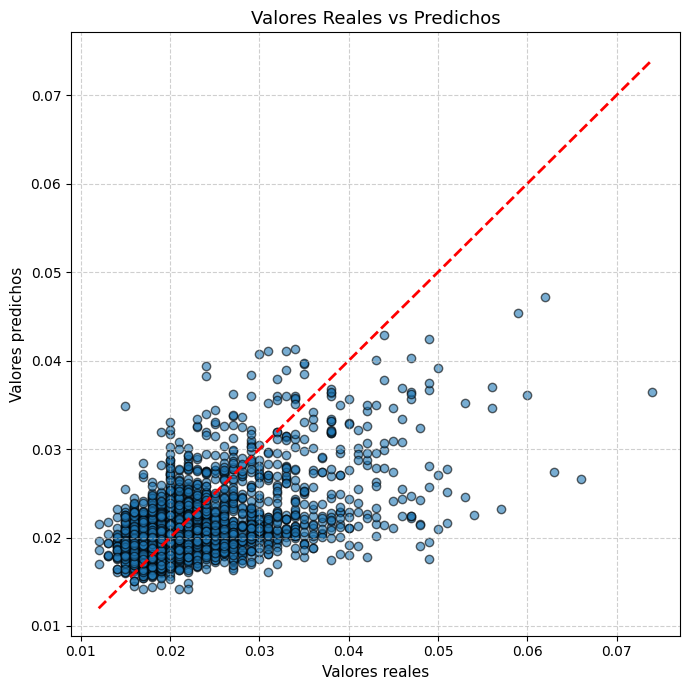

In [ ]:
# ====================================================
# 📈 GRÁFICA: VALORES REALES VS PREDICHOS
# ====================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)

plt.title("Valores Reales vs Predichos", fontsize=13)
plt.xlabel("Valores reales", fontsize=11)
plt.ylabel("Valores predichos", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



🧩 Circuito cuántico completo (Feature Map + Ansatz):


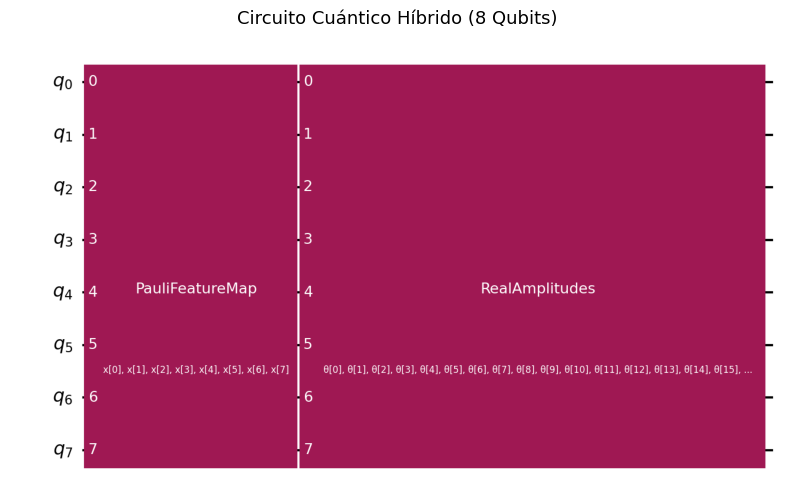


🔤 Representación en texto:
     ┌───────────────────────────────────────────────────────────┐»
q_0: ┤0                                                          ├»
     │                                                           │»
q_1: ┤1                                                          ├»
     │                                                           │»
q_2: ┤2                                                          ├»
     │                                                           │»
q_3: ┤3                                                          ├»
     │  PauliFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]) │»
q_4: ┤4                                                          ├»
     │                                                           │»
q_5: ┤5                                                          ├»
     │                                                           │»
q_6: ┤6                                                          ├»
     │              

In [ ]:
# =============================================
# ⚛️ Visualización del circuito con Qiskit (versión funcional)
# =============================================

from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

print("\n🧩 Circuito cuántico completo (Feature Map + Ansatz):")

# ✅ Dibujar y guardar directamente con circuit_drawer
fig_path = "hybrid_qnn_circuit_qiskit.png"
circuit_drawer(
    qc,
    output="mpl",
    style="iqp",
    filename=fig_path,  # guarda automáticamente la imagen
)

# Mostrar la figura manualmente
img = plt.imread(fig_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Circuito Cuántico Híbrido (8 Qubits)", fontsize=13)
plt.show()

# ---------------------------------------------
# 🔤 Representación ASCII
# ---------------------------------------------
print("\n🔤 Representación en texto:")
print(qc.draw(output="text"))

# ---------------------------------------------
# 🔍 Detalles adicionales del circuito
# ---------------------------------------------
input_param_list = list(feature_map.parameters)
weight_param_list = list(ansatz.parameters)

print("\n📋 Información del circuito:")
print(f"• Número de qubits: {qc.num_qubits}")
print(f"• Número de compuertas: {qc.size()}")
print(f"• Profundidad del circuito: {qc.depth()}")
print(f"• Parámetros totales: {len(qc.parameters)}")
print(f"• Parámetros de entrada: {[p.name for p in input_param_list]}")
print(f"• Parámetros de pesos:  {[p.name for p in weight_param_list]}")

print(f"\n🖼️ Circuito guardado como '{fig_path}'")
